## Importing the needed packages 

In [44]:
#Packages
import requests
# from bs4 import BeautifulSoup
# import re
# import selenium
import time
import pandas as pd
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from bs4 import BeautifulSoup
import re
import json
import tqdm
from time import sleep

import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

# Scraping the data
    
This is the initial part of the notebook where we start scraping the data from Vivino web site, first we used an API that gave us around 35k wines.

## First Scrape

This part contains a function called scrape_wines. The function loops through a specified explore category on Vivino.com, and collects data about all wines in that category. The loop stores the data in a dataframe and saves it to the working directory for later use. 

The function takes the following input:
- price_min: The minimum price of the wines you want to collect
- price_max: The maximum price of the wines you want to collect
- wine_type: A number from 1 to 200+, that specifies the wine type. 1 = red wine, 2=white wine, 3=sparkling wine, 4=rosé.

Code break down: 
- The url is defines based on the given input. 
- The url is requested for the first page using the Request package. This first request is used collect the number of wines in the given category. The request contains a header that describes who we are, and why we are collecting the data. It also gives our contact information.
- The number of wines in the category is collected and stored.
- The number of wines per page is defined as 25
- The empty list 'wine_list' is created. We later add data from each requested page to the list. 
- A loop is created for i in range 0 to the total number of full pages. 
- The url for page i+1 is requested using the Request package. This request is used collect information about all the wines on the given page. The request contains a header that describes who we are, and why we are collecting the data. It also gives our contact information.
- Then (still in the loop) the relevant information from the request is stored in a data frame and appended to 'wine_list'
- The function sleeps for one second, as Vivino.dk has requested, that we do not send more than a 100 requests per minute.
- After the loop has finished running, the data frames are concatenated to one big data frame called 'wine_df' and the index in reset. 
- 'wine_df' is stored in the working directory as first_scrape_"wine_type".


In [2]:
def scrape_wines(price_min, price_max, wine_type):
    tic = time.time()

    r_list=[]
    url=f'https://www.vivino.com/api/explore/explore?country_code=DK&currency_code=DKK&grape_filter=varietal&min_rating=1&order_by=&order=&page=1&price_range_max={price_max}&price_range_min={price_min}&wine_type_ids[]={wine_type}'
    r = requests.get(url,
                 headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36', 'About':'Students from UCPH collecting wine dara for our social data science project',  
                          'contact': 'mkw730@alumni.ku.dk'})
    number_of_wines=r.json()['explore_vintage']['records_matched']
    nuber_per_page=25
    wine_list=[]
    for i in range(round(number_of_wines/nuber_per_page)): 
        r = requests.get(f'https://www.vivino.com/api/explore/explore?country_code=DK&currency_code=DKK&\
            grape_filter=varietal&min_rating=1&order_by=&order=&page={i+1}\
            &price_range_max={price_max}&price_range_min={price_min}&wine_type_ids[]={wine_type}',
                 headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36', 'About':'Students from UCPH collecting wine dara for our social data science project',  
                          'contact': 'mkw730@alumni.ku.dk'})
        r_list.append(r.json())
        
        
        results = []
        for t in r.json()["explore_vintage"]["matches"]:
            
            try:
                instance = (t["vintage"]["wine"]["winery"]["name"],
                t["vintage"]["wine"]["name"],
                t["vintage"]["year"],
                t["vintage"]["statistics"]["ratings_average"],
                t["vintage"]["statistics"]["ratings_count"],
                t["price"]["amount"],
                t["price"]["discounted_from"],
                t["vintage"]["wine"]["region"]["country"]["name"],
                t["vintage"]["wine"]["region"]["name"],
                t["vintage"]["wine"]["id"],
                t["price"]["id"],
                t["vintage"]["wine"]["type_id"],
                t["vintage"]["wine"]["seo_name"],
                t["vintage"]["wine"]["winery"]["seo_name"])
                results.append(instance)
            
            except:
                try:
                    # Try changeing this until it works by replacing the problematic data with None
                    instance = (t["vintage"]["wine"]["winery"]["name"],
                    t["vintage"]["wine"]["name"],
                    t["vintage"]["year"],
                    t["vintage"]["statistics"]["ratings_average"],
                    t["vintage"]["statistics"]["ratings_count"],
                    t["price"]["amount"],
                    t["price"]["discounted_from"],
                    t["vintage"]["wine"]["region"]["country"]["name"],
                    t["vintage"]["wine"]["region"]["name"],
                    t["vintage"]["wine"]["id"],
                    t["price"]["id"],
                    t["vintage"]["wine"]["type_id"],
                    t["vintage"]["wine"]["seo_name"],
                    )
                    results.append(instance)
                except:
                    try:
                        instance = (t["vintage"]["wine"]["winery"]["name"],
                        t["vintage"]["wine"]["name"],
                        t["vintage"]["year"])
                        results.append(instance)
                    except:
                        instance = (t["vintage"]["wine"]["name"],
                        t["vintage"]["year"])
                        results.append(instance)
                
        dataframe = pd.DataFrame(results,columns=['Winery','Wine',"Year",'Rating','num_review',"price","discounted_from","country","region","wine_id","price_id","type_id","Wine_seo","Winery_seo"])
        
        l2=[]
        l_no=[]
        for i in range(len(r.json()["explore_vintage"]["matches"])):
            "This loop is extracting the grapes and append None in a list"
            if r.json()["explore_vintage"]["matches"][i]["vintage"]["wine"]["style"]!=None:
                lgrape=[]
                for j in range(len(r.json()["explore_vintage"]["matches"][i]["vintage"]["wine"]["style"]["grapes"])):
                    lgrape.append(r.json()["explore_vintage"]["matches"][i]["vintage"]["wine"]["style"]["grapes"][j]["name"])  
                l2.append(lgrape)
        
            else:
                l_no.append(r.json()["explore_vintage"]["matches"][i]["vintage"]["wine"])
                l2.append(None)
            
        dataframe["Grapetype"] = l2
        with open(f'first_scrape_{wine_type}_{price_min}_to_{price_max}_json.txt', "w", encoding='utf-8') as output:
            output.write(str(r_list)) 
        wine_list.append(dataframe)
        time.sleep(1)
        
        wine_df=pd.concat(wine_list)
        wine_df = wine_df.reset_index(drop=True)
        wine_df.to_csv(f'first_scrape_{wine_type}_{price_min}_to_{price_max}.csv')
        
        
    toc = time.time() 
    print('Number of wines in total:', number_of_wines,f'Funtion ran for {toc-tic:.1f}')
    return wine_df

The following is a small example to show how it works. 
the function collects data from wines of type 4 - Sparkling Wine - in the price range 100 DKK to 110DKK, we divide the data scraping in chunks by price and wine type so the scraping don´t became tedious and we could check if we find an error (and we did), so the whole data was compromised

In [ ]:
wine_df1 = scrape_wines(price_min=0, price_max=200, wine_type=1) #Red Wine
wine_df2 = scrape_wines(price_min=0, price_max=200, wine_type=2) #930 white
wine_df3 = scrape_wines(price_min=0, price_max=200, wine_type=3) #124 Sparkling
wine_df4 = scrape_wines(price_min=0, price_max=200, wine_type=4) #83 Rose

In [ ]:
wine_df1_200_to_400 = scrape_wines(price_min=200.1, price_max=400, wine_type=1) #Red Wine
wine_df2_200_to_400 = scrape_wines(price_min=200.1, price_max=400, wine_type=2) #930 white
wine_df3_200_to_400 = scrape_wines(price_min=200.1, price_max=400, wine_type=3) #124 Sparkling
wine_df4_200_to_400 = scrape_wines(price_min=200.1, price_max=400, wine_type=4) #83 Rose

In [ ]:
wine_df1_400_to_2000 = scrape_wines(price_min=400.1, price_max=2000, wine_type=1) #Red Wine
wine_df2_400_to_2000 = scrape_wines(price_min=400.1, price_max=2000, wine_type=2) #930 white
wine_df3_400_to_2000 = scrape_wines(price_min=400.1, price_max=2000, wine_type=3) #124 Sparkling
wine_df4_400_to_2000 = scrape_wines(price_min=400.1, price_max=2000, wine_type=4) #Rose

### Importing the data

In [7]:
#This is how data used to be imported. For now this is not used. It can be used again if the data changes.

#Data for wine that costs less than DKK 200 are imported.
wine_df_red_low = pd.read_csv('first_scrape_1.csv')
wine_df_white_low = pd.read_csv('first_scrape_2.csv')
wine_df_spark_low = pd.read_csv('first_scrape_3.csv')
wine_df_rose_low = pd.read_csv('first_scrape_4.csv')

# #Data for wine that costs between DKK 200 and 400 are imported.
wine_df_red_mid = pd.read_csv('first_scrape_1_200_to_400.csv')
wine_df_white_mid = pd.read_csv('first_scrape_2_200_to_400.csv')
wine_df_spark_mid = pd.read_csv('first_scrape_3_200_to_400.csv')
wine_df_rose_mid = pd.read_csv('first_scrape_4_200_to_400.csv')

# #Data for wine that costs between DKK 400 and 2000 are imported.
wine_df_red_high = pd.read_csv('first_scrape_1_400_to_2000.csv')
wine_df_white_high = pd.read_csv('first_scrape_2_400_to_2000.csv')
wine_df_spark_high = pd.read_csv('first_scrape_3_400_to_2000.csv')
wine_df_rose_high = pd.read_csv('first_scrape_4_400_to_2000.csv')

data = pd.concat([wine_df_red_low, wine_df_white_low, wine_df_spark_low, wine_df_rose_low,
                   wine_df_red_mid, wine_df_white_mid, wine_df_spark_mid, wine_df_rose_mid, 
                   wine_df_red_high, wine_df_white_high, wine_df_spark_high, wine_df_rose_high], ignore_index=True)

data.to_csv('Data_all.csv')
data=data.drop(['Unnamed: 0', 'price_id', 'wine_id', 'Winery_seo', 'Wine_seo'],axis=1)
# data = data.reset_index(drop=True)
data.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,type_id,Grapetype
0,Rinforzo,Primitivo Salento,2019,4.5,319.0,129.0,179.0,Italien,Salento,1.0,['Primitivo']
1,Caballo Loco,Grand Cru Apalta,2018,4.5,95.0,141.5,249.0,Chile,Colchagua Valley,1.0,"['Cabernet Sauvignon', 'Cabernet Franc', 'Malb..."
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1478.0,149.0,NaN,Italien,Primitivo di Manduria,1.0,['Primitivo']
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,315.0,199.0,NaN,Italien,Isola dei Nuraghi,1.0,"['Primitivo', 'Aglianico', 'Negroamaro', ""Nero..."
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,211.0,199.0,329.0,Italien,Amarone della Valpolicella,1.0,"['Corvina', 'Rondinella', 'Corvinone']"


## Second Scrape

### Preparing for scraping

1. The data from the first round of scraping is loaded.
2. Making the mapping for wine urls.


In [8]:
#Loading the dataset
df=pd.read_csv("Data_all.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

df.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,price_id,type_id,Wine_seo,Winery_seo,Grapetype
0,Rinforzo,Primitivo Salento,2019,4.5,319.0,129.0,179.0,Italien,Salento,1385662.0,25155854.0,1.0,primitivo-salento,rinforzo,['Primitivo']
1,Caballo Loco,Grand Cru Apalta,2018,4.5,95.0,141.5,249.0,Chile,Colchagua Valley,4837001.0,25454999.0,1.0,grand-cru-apalta,caballo-loco,"['Cabernet Sauvignon', 'Cabernet Franc', 'Malb..."
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1478.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,23677397.0,1.0,papale-linea-oro-primitivo-di-manduria,varvaglione,['Primitivo']
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,315.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,25563701.0,1.0,korem-bovale-isola-dei-nuraghi,argiolas,"['Primitivo', 'Aglianico', 'Negroamaro', ""Nero..."
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,211.0,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,24181693.0,1.0,ca-de-rocchi-amarone-della-valpolicella-la-bastia,tinazzi,"['Corvina', 'Rondinella', 'Corvinone']"


In [9]:
#Retrieving the wine urls
wine_url=[]

for winery, wine, wine_id,year in tqdm.tqdm(zip(df["Winery_seo"],df["Wine_seo"],df["wine_id"],df["Year"])):
    ult_url=f"https://www.vivino.com/DK/en/{winery}-{wine}/w/{wine_id:.0f}?year={year}"
    wine_url.append(ult_url)

df["wine_url"]=wine_url

35643it [00:00, 318319.71it/s]


In [11]:
#Doing the scraping in partitions to prevent loss of all data in case of error
#For demonstration purposes we only scrape 10 wines.
small_df=df[:10]

small_df=small_df.reset_index(drop=True)

small_df.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,price_id,type_id,Wine_seo,Winery_seo,Grapetype,wine_url
0,Rinforzo,Primitivo Salento,2019,4.5,319.0,129.0,179.0,Italien,Salento,1385662.0,25155854.0,1.0,primitivo-salento,rinforzo,['Primitivo'],https://www.vivino.com/DK/en/rinforzo-primitiv...
1,Caballo Loco,Grand Cru Apalta,2018,4.5,95.0,141.5,249.0,Chile,Colchagua Valley,4837001.0,25454999.0,1.0,grand-cru-apalta,caballo-loco,"['Cabernet Sauvignon', 'Cabernet Franc', 'Malb...",https://www.vivino.com/DK/en/caballo-loco-gran...
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1478.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,23677397.0,1.0,papale-linea-oro-primitivo-di-manduria,varvaglione,['Primitivo'],https://www.vivino.com/DK/en/varvaglione-papal...
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,315.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,25563701.0,1.0,korem-bovale-isola-dei-nuraghi,argiolas,"['Primitivo', 'Aglianico', 'Negroamaro', ""Nero...",https://www.vivino.com/DK/en/argiolas-korem-bo...
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,211.0,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,24181693.0,1.0,ca-de-rocchi-amarone-della-valpolicella-la-bastia,tinazzi,"['Corvina', 'Rondinella', 'Corvinone']",https://www.vivino.com/DK/en/tinazzi-ca-de-roc...


# Begin scraping

* For each link we retrieved the soup, extracted the json from the soup, found the data we wanted and appended it to a list.
* At the end we added the list to the df as a new column.
* To mitigate errors we implemented try/exception clauses.

In [15]:
num_reviews=[]
ratings_distribution=[]
rating_average = []
grapes=[]
alcohol=[]
offer=[]
extra_error=[]
one=[]
two=[]
three=[]
four=[]
five=[]
no_t=[]
counter=0

offer_num=0
error=0

for u in tqdm.tqdm(small_df["wine_url"]):
    """
    Takes links as input, returns df with new columns
    """
    if counter<11:
        counter+=1
    else:
        counter=0
        print(f"alcohol length: {len(alcohol)}")
        print(f"grapes length: {len(grapes)}")
        print(f"ratings_distribution length: {len(ratings_distribution)}")
        print(f"rating_average length: {len(rating_average)}")
        print(f"Errors: {error}")
        print(f"Num offers: {offer_num}")
        
    sleep(0.5)
    
    r = requests.get(u,
                     headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36', 'About':'Students from UCPH collecting wine dara for our social data science project',  
                                  'contact': 'mkw730@alumni.ku.dk'})
    
    soup = BeautifulSoup(r.content, 'html.parser')

    if r.ok==True and "window.__PRELOADED_STATE__.vintagePageInformation" in soup.text:
        pattern = re.compile(r"window\.__PRELOADED_STATE__\.vintagePageInformation = (.*);", re.MULTILINE)

        script = soup.find("script", text=lambda x: x and "window.__PRELOADED_STATE__.vintagePageInformation" in x).text

        data = json.loads(re.search(pattern, script).group(1))
        
        try:
            num_reviews.append(data["vintage"]["statistics"]["ratings_count"])
        except:
            num_reviews.append(None)
            
        try:
            rating_average.append(data["vintage"]["statistics"]["ratings_average"])
        except:
            rating_average.append(None)
            
        try:
            ratings_distribution.append(data["vintage"]["ratings_distribution"])
        except:
            ratings_distribution.append(None)
            
        try:
            grapy=[]
            for grape in range(len(data["vintage"]["wine"]["grapes"])):
                grapy.append(data["vintage"]["wine"]["grapes"][grape]["name"])
            grapes.append(grapy)
        except:
            grapes.append(None)
            
        try:
            alcohol.append(data["vintage"]['wine_facts']["alcohol"])
        except:
            alcohol.append(None)

    elif r.ok==True and "window.__PRELOADED_STATE__.offerPageInformation" in soup.text: 
        offer.append(u)
        offer_num+=1
        
        rating_average.append(None)
        num_reviews.append(None)
        ratings_distribution.append(None)
        alcohol.append(None)
        grapes.append(None)
        
    elif r.ok==True and "window.__PRELOADED_STATE__.winePageInformation" in soup.text:
        script = soup.find("script", text=lambda x: x and "window.__PRELOADED_STATE__.winePageInformation" in x).text
        pattern = re.compile(r"window\.__PRELOADED_STATE__\.winePageInformation = (.*);", re.MULTILINE)
        data = json.loads(re.search(pattern, script).group(1))
        
        try:
            num_reviews.append(data["vintage"]["statistics"]["ratings_count"])
        except:
            num_reviews.append(None)
            
        try:
            ratings_distribution.append(data["vintage"]["ratings_distribution"])
        except:
            ratings_distribution.append(None)
            
        try:
            rating_average.append(data["vintage"]["statistics"]["ratings_average"])
        except:
            rating_average.append(None)
        
        try:
            grapy=[]
            for grape in range(len(data["vintage"]["wine"]["grapes"])):
                grapy.append(data["vintage"]["wine"]["grapes"][grape]["name"])
            grapes.append(grapy)
        except:
            grapes.append(None)
            
        try:
            alcohol.append(data["vintage"]['wine']["alcohol"])
        except:
            alcohol.append(None)

    elif r.ok==False:
        error+=1
        rating_average.append(None)
        num_reviews.append(None)
        ratings_distribution.append(None)
        alcohol.append(None)
        grapes.append(None)
    else:
        error+=1
        rating_average.append(None)
        num_reviews.append(None)
        ratings_distribution.append(None)
        alcohol.append(None)
        grapes.append(None)
        

for rat in ratings_distribution:
    if rat!=None:
        for key, value in rat.items():
            if key=="1":
                one.append(value)
            elif key=="2":
                two.append(value)
            elif key=="3":
                three.append(value)
            elif key=="4":
                four.append(value)
            elif key=="5":
                five.append(value)
            else:
                no_t.append(rat)
    elif rat==None:
        one.append(None)
        two.append(None)
        three.append(None)
        four.append(None)
        five.append(None)

#Checking if all list are the same length
print(f"alcohol length: {len(alcohol)}")
print(f"grapes length: {len(grapes)}")
print(f"ratings_distribution length: {len(ratings_distribution)}")
print(f"rating_average length: {len(rating_average)}")
print(f"one length: {len(one)}")
print(f"two length: {len(two)}")
print(f"three length: {len(three)}")
print(f"four length: {len(four)}")
print(f"five length: {len(five)}")
print(f"Errors: {error}")
print(f"Num offers: {offer_num}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.19s/it]


alcohol length: 10
grapes length: 10
ratings_distribution length: 10
rating_average length: 10
one length: 10
two length: 10
three length: 10
four length: 10
five length: 10
Errors: 0
Num offers: 3


In [16]:
#Adding the new columns to the df
small_df["ratings_distribution"]=ratings_distribution
small_df["updated_rating"] = rating_average
small_df["grapes_real"]=grapes
small_df["alcohol"]=alcohol
small_df["one"]=one
small_df["two"]=two
small_df["three"]=three
small_df["four"]=four
small_df["five"]=five
small_df["num_review"]=num_reviews
small_df.to_csv("wines_10.csv")
small_df.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,...,wine_url,ratings_distribution,updated_rating,grapes_real,alcohol,one,two,three,four,five
0,Rinforzo,Primitivo Salento,2019,4.5,331.0,129.0,179.0,Italien,Salento,1385662.0,...,https://www.vivino.com/DK/en/rinforzo-primitiv...,"{'1': 3, '2': 5, '3': 23, '4': 140, '5': 160}",4.5,[Primitivo],14.5,3.0,5.0,23.0,140.0,160.0
1,Caballo Loco,Grand Cru Apalta,2018,4.5,NaN,141.5,249.0,Chile,Colchagua Valley,4837001.0,...,https://www.vivino.com/DK/en/caballo-loco-gran...,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1496.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,...,https://www.vivino.com/DK/en/varvaglione-papal...,"{'1': 4, '2': 10, '3': 106, '4': 907, '5': 469}",4.4,[Primitivo],14.5,4.0,10.0,106.0,907.0,469.0
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,322.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,...,https://www.vivino.com/DK/en/argiolas-korem-bo...,"{'1': 0, '2': 1, '3': 24, '4': 214, '5': 83}",4.4,[Bovale],NaN,0.0,1.0,24.0,214.0,83.0
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,NaN,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,...,https://www.vivino.com/DK/en/tinazzi-ca-de-roc...,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


# Concatenating all the df into one

In [ ]:
#Loading all the data and dropping irrelevant columns
first=pd.read_csv("data_first_5000.csv")
first=first.drop(['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'], axis=1)
second=pd.read_csv("data_5000_15000.csv")
second=second.drop(['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1',"index"], axis=1)
four=pd.read_csv("data_20000_25000.csv")
four=four.drop(['Unnamed: 0'], axis=1)
five=pd.read_csv("data_25000_30000.csv")
five=five.drop(['Unnamed: 0'], axis=1)
six=pd.read_csv("data_30000_33000.csv")
six=six.drop(['Unnamed: 0'], axis=1)
seven=pd.read_csv("data_33000_35642.csv")
seven=seven.drop(['Unnamed: 0'], axis=1)

#Concatenating
winelist=[first,second,third,four,five,six,seven]
wine_df=pd.concat(winelist)
wine_df=wine_df.reset_index(drop=True)

In [ ]:
#Saving df into csv
wine_df.to_csv("final_wine_scrape.csv")

In [3]:
final_wine_scrape=pd.read_csv("final_wine_scrape.csv")
final_wine_scrape.head()

,Unnamed: 0,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,...,wine_url,ratings_distribution,updated_rating,grapes_real,alcohol,one,two,three,four,five
0,0,Rinforzo,Primitivo Salento,2019,4.5,NaN,129.0,179.0,Italien,Salento,...,https://www.vivino.com/DK/en/rinforzo-primitiv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Caballo Loco,Grand Cru Apalta,2018,4.5,NaN,141.5,249.0,Chile,Colchagua Valley,...,https://www.vivino.com/DK/en/caballo-loco-gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1484.0,149.0,NaN,Italien,Primitivo di Manduria,...,https://www.vivino.com/DK/en/varvaglione-papal...,"{'1': 4, '2': 9, '3': 105, '4': 901, '5': 465}",4.4,['Primitivo'],14.5,4.0,9.0,105.0,901.0,465.0
3,3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,320.0,199.0,NaN,Italien,Isola dei Nuraghi,...,https://www.vivino.com/DK/en/argiolas-korem-bo...,"{'1': 0, '2': 1, '3': 24, '4': 212, '5': 83}",4.4,['Bovale'],NaN,0.0,1.0,24.0,212.0,83.0
4,4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,NaN,199.0,329.0,Italien,Amarone della Valpolicella,...,https://www.vivino.com/DK/en/tinazzi-ca-de-roc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Importing the final data

In [ ]:
# This is how data used to be imported. For now this is not udsed. It can be used again if the data changes.

# #Data for wine that costs less than DKK 200 are imported.
# wine_df_red_low = pd.read_csv('first_scrape_1.csv')
# wine_df_white_low = pd.read_csv('first_scrape_2.csv')
# wine_df_spark_low = pd.read_csv('first_scrape_3.csv')
# wine_df_rose_low = pd.read_csv('first_scrape_4.csv')

# #Data for wine that costs between DKK 200 and 400 are imported.
# wine_df_red_mid = pd.read_csv('first_scrape_1_200_to_400.csv')
# wine_df_white_mid = pd.read_csv('first_scrape_2_200_to_400.csv')
# wine_df_spark_mid = pd.read_csv('first_scrape_3_200_to_400.csv')
# wine_df_rose_mid = pd.read_csv('first_scrape_4_200_to_400.csv')

# #Data for wine that costs between DKK 400 and 2000 are imported.
# wine_df_red_high = pd.read_csv('first_scrape_1_400_to_2000.csv')
# wine_df_white_high = pd.read_csv('first_scrape_2_400_to_2000.csv')
# wine_df_spark_high = pd.read_csv('first_scrape_3_400_to_2000.csv')
# wine_df_rose_high = pd.read_csv('first_scrape_4_400_to_2000.csv')

# data = pd.concat([wine_df_red_low, wine_df_white_low, wine_df_spark_low, wine_df_rose_low,
#                   wine_df_red_mid, wine_df_white_mid, wine_df_spark_mid, wine_df_rose_mid, 
#                   wine_df_red_high, wine_df_white_high, wine_df_spark_high, wine_df_rose_high], ignore_index=True)
# # data=wine_df_red

# data.to_csv('Data_all.csv')
# data=data.drop(['Unnamed: 0', 'price_id', 'wine_id', 'Winery_seo', 'Wine_seo'],axis=1)
# data = data.reset_index(drop=True)

In [17]:
#Importing data
data=pd.read_csv('final_wine_scrape.csv')
data=data.drop(['Unnamed: 0', 'price_id', 'Winery_seo', 'Wine_seo', 'ratings_distribution', 'Grapetype', 'wine_url'],axis=1)
data = data.reset_index(drop=True)
data = data.drop_duplicates(['Wine', 'Winery','Year','type_id','wine_id'], keep='first')
data.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,type_id,updated_rating,grapes_real,alcohol,one,two,three,four,five
0,Rinforzo,Primitivo Salento,2019,4.5,NaN,129.0,179.0,Italien,Salento,1385662.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Caballo Loco,Grand Cru Apalta,2018,4.5,NaN,141.5,249.0,Chile,Colchagua Valley,4837001.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1484.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,1.0,4.4,['Primitivo'],14.5,4.0,9.0,105.0,901.0,465.0
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,320.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,1.0,4.4,['Bovale'],NaN,0.0,1.0,24.0,212.0,83.0
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,NaN,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the data

In this part of the notebook, we are inspecting the data and cleaning what is needed to fit in our model

In [18]:
from numpy import NaN
data = data.replace('N.V.', NaN)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13980 entries, 0 to 35642
Data columns (total 19 columns):
Winery             13980 non-null object
Wine               13980 non-null object
Year               12819 non-null object
Rating             13974 non-null float64
num_review         13787 non-null float64
price              13974 non-null float64
discounted_from    302 non-null float64
country            13974 non-null object
region             13974 non-null object
wine_id            13974 non-null float64
type_id            13974 non-null float64
updated_rating     13787 non-null float64
grapes_real        13787 non-null object
alcohol            9741 non-null float64
one                13787 non-null float64
two                13787 non-null float64
three              13787 non-null float64
four               13787 non-null float64
five               13787 non-null float64
dtypes: float64(13), object(6)
memory usage: 2.1+ MB


In [19]:
data.isnull().sum()

Winery                 0
Wine                   0
Year                1161
Rating                 6
num_review           193
price                  6
discounted_from    13678
country                6
region                 6
wine_id                6
type_id                6
updated_rating       193
grapes_real          193
alcohol             4239
one                  193
two                  193
three                193
four                 193
five                 193
dtype: int64

## Handling Missing Values

Most wines in the data (35057 out of 35643) have missings in the category 'discounted_from'. This is because 'discounted_from' only has a value if the wine was on offer when data was extracted from the website. If 'discounted_from' has a value, it shows the original price of the wine. We assume that most wines are reviewed based on their original price, and therefore we will use 'discounted_from' instead of the price in the column 'price', as 'price' in that case shows the offer price. We will return to this later, bit this is the reason why we do not handle these missings right now.

Some wines have missing values in the 'Year' column (1164 out of 35643). We will look at these values later. NEEDS TO BE FIGURED OUT.

We where not able to collect gapes from the json from the explore page. We are working on collecting these in an other way. NEEDS TO BE FIGURED OUT.

From the code: 'data.info()' it seems like there is around 6 rows, that might be causing problems, since there is 6 null value in a lot of the columns ('Rating', 'price', ect.). We will in the following try and find this wine, to see how to handle the missings. We will either collect the data in another way or drop the wines with missing in these categories. 

In [20]:
data_find_null=data.drop(['discounted_from', 'Year','updated_rating','grapes_real','alcohol','one','two','three','four','five','num_review'],axis=1)
#The columns 'discounted_from', 'Grapetype', 'Year' are removed from this data 
#so we can use this dataset to show only rows with missing values in any of the other categories.
data_find_null[data_find_null.isnull().any(axis=1)]

,Winery,Wine,Rating,price,country,region,wine_id,type_id
20486,Mondo del Vino,Badia San Mercuriale,NaN,NaN,NaN,NaN,NaN,NaN
20803,Tvoja KRV I Moja Cabernet Sauvignon-Merlot,2015,NaN,NaN,NaN,NaN,NaN,NaN
25743,Laroche,L Chablis,NaN,NaN,NaN,NaN,NaN,NaN
25877,Isole e Olena,Chardonnay Toscana Collezione Privata,NaN,NaN,NaN,NaN,NaN,NaN
27819,Costaripa,Molmenti,NaN,NaN,NaN,NaN,NaN,NaN
34487,Isole e Olena,Chardonnay Toscana Collezione Privata,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
Missing_list=data_find_null[data_find_null.isnull().any(axis=1)]['Wine'].tolist()
Missing_list

['Badia San Mercuriale',
 '2015',
 'L Chablis',
 'Chardonnay Toscana Collezione Privata',
 'Molmenti',
 'Chardonnay Toscana Collezione Privata']

We se the wines that are causing trouble. One of them is a wine called 'Chardonnay Toscana Collezione Privata', it can be viewed in the following link: https://www.vivino.com/DK/en/isole-e-olena-chardonnay-toscana-collezione-privata/w/1240491. For some reason our scraping does not pick up values for this wine, it is not really clear why. This wine is also not for sale on Vivino, but is only shown because it has been rated by users. This might be why it does not have a price. 

The wine in the third row looks as a clear reading error as a year is shown instead of a wine name. But by looking at the wine through the link: https://www.vivino.com/DK/en/tvoja-krv-i-moja-cabernet-sauvignon-merlot-red-wine-v-tahoy/w/4359738, It is clear that this wine is also not for sale on Vivino, but is only shown because it has been rated by users. This might be why it does not have a price. 

By looking closer at the six wines it is clear, that these wines have missings because they are not sold through Vivino.dk. We therefore choose to drop all six wines. We create a new dataframe 'df' where the six rows are removed.

In [22]:
df = data[~data['Wine'].isin(Missing_list)]
print(len(data)-len(df), 'rows whit missing values have sucsessfully been removed')
print(f"In total the rows removed due to missing values amount to {round((len(data)-len(df))/len(data)*100,2)} % of the rows in the original data")
ndf = df.reset_index(drop=True)

6 rows whit missing values have sucsessfully been removed
In total the rows removed due to missing values amount to 0.04 % of the rows in the original data


We decided to look closer at the wines with missing years. We are thinking of computing the age of the wine, and therfore we wille just compute the age of the wine as 0, for wines with missings, so the year is not weighted for these wines. 

In [23]:
#Taking the original price
ndf['True_price'] = ndf['price'] 
#if df['True_price'] < df['discounted_from'] : df['True_price'] = df['discounted_from']
ndf['True_price'] = ndf.apply(lambda x: x['discounted_from'] if x['True_price']< x['discounted_from'] else x['True_price'], axis=1)
#df = df.drop(['Unnamed: 0.1'],axis=1)

In [24]:
ndf.dtypes

Winery              object
Wine                object
Year                object
Rating             float64
num_review         float64
price              float64
discounted_from    float64
country             object
region              object
wine_id            float64
type_id            float64
updated_rating     float64
grapes_real         object
alcohol            float64
one                float64
two                float64
three              float64
four               float64
five               float64
True_price         float64
dtype: object

The blocked out code below was used earlier to remove wines with missings in year.

We want to show the age of the wine. Therfore we import the current year and calculate the difference between current year at the vintage of the wine.

In [33]:
currentYear = datetime.now().year #Getting current year
ndf['Today'] = currentYear #creating actual year
ndf['Year'] = ndf['Year'].fillna('2021') #fill all NaN with 2021
ndf.Year = ndf.Year.astype('float')#changing the year column to float because one value is 2015.0
ndf['Year'] = ndf['Year'].astype(int)
ndf = ndf.assign(age = ndf['Today'] - ndf['Year']) #getting the actual age of the of the wine
# del df['Today'] # actual year is not useful so we drop it

ndf['Calculated rating'] = (ndf['one'] * 1 + ndf['two'] * 2 + ndf['three'] * 3 + ndf['four'] * 4 + ndf['five'] *5)/(ndf['one']+ndf['two']+ndf['three'] + ndf['four'] + ndf['five'])


ndf['rat_dev'] = ndf['updated_rating'] - ndf['Calculated rating']

#print(ndf['rat_dev'].mean(),ndf['rat_dev_1'].mean(),ndf['rat_dev_2'].mean())

#ndf = ndf.drop(['rat_dev_1','rat_dev_2'],axis=1)
ndf.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,...,one,two,three,four,five,True_price,Today,age,Calculated rating,rat_dev
0,Rinforzo,Primitivo Salento,2019,4.5,NaN,129.0,179.0,Italien,Salento,1385662.0,...,NaN,NaN,NaN,NaN,NaN,179.0,2021,2,NaN,NaN
1,Caballo Loco,Grand Cru Apalta,2018,4.5,NaN,141.5,249.0,Chile,Colchagua Valley,4837001.0,...,NaN,NaN,NaN,NaN,NaN,249.0,2021,3,NaN,NaN
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1484.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,...,4.0,9.0,105.0,901.0,465.0,149.0,2021,4,4.222372,0.177628
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,320.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,...,0.0,1.0,24.0,212.0,83.0,199.0,2021,4,4.178125,0.221875
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,NaN,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,...,NaN,NaN,NaN,NaN,NaN,329.0,2021,4,NaN,NaN


We decide to replace the missing values in the alcohol column with the average alcohol percent.

In [34]:
ndf['alcohol_new']=ndf['alcohol'].fillna(ndf['alcohol'].mean())
ndf['alcohol_new']

0        12.93592
1        12.93592
2        14.50000
3        12.93592
4        12.93592
5        12.93592
6        12.93592
7        12.93592
8        12.93592
9        14.00000
10       13.50000
11       12.93592
12       13.50000
13       12.93592
14       12.93592
15       14.00000
16       14.00000
17       17.50000
18       12.93592
19       14.50000
20       15.50000
21       12.93592
22       15.00000
23       14.00000
24       15.00000
25       12.93592
26       12.93592
27       16.00000
28       13.50000
29       12.93592
           ...   
13944    12.93592
13945    12.93592
13946    12.93592
13947    12.93592
13948    12.50000
13949    12.00000
13950    11.50000
13951    12.00000
13952    12.00000
13953    12.93592
13954    12.93592
13955    12.93592
13956    12.93592
13957    12.93592
13958    12.93592
13959    12.93592
13960    12.93592
13961    12.00000
13962    12.93592
13963    11.00000
13964    12.93592
13965    14.00000
13966    13.00000
13967    14.00000
13968    1

We are now gonna drop the columns, that are not going to be used for the machinelearning and save the resulting dataframe as a new file.

In [36]:
ndf_ml=ndf.dropna(subset=(['num_review']))
ndf_ml=ndf_ml.drop(['discounted_from', 'price', 'Year', 'Winery', 'Today', 'region', 'one', 'two', 'three', 'four', 'five', 'Calculated rating', 'rat_dev', 'wine_id', 'alcohol', 'updated_rating' ], axis=1)

ndf_ml.head()

,Wine,Rating,num_review,country,type_id,grapes_real,True_price,age,alcohol_new
2,Papale Linea Oro Primitivo di Manduria,4.4,1484.0,Italien,1.0,['Primitivo'],149.0,4,14.50000
3,Korem Bovale Isola dei Nuraghi,4.4,320.0,Italien,1.0,['Bovale'],199.0,4,12.93592
7,Edizione Cinque Autoctoni,4.4,52.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",149.0,1,12.93592
8,Langhe Rosso,4.4,35.0,Italien,1.0,['Nebbiolo'],140.0,1,12.93592
9,Edizione Cinque Autoctoni,4.3,59716.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",249.0,0,14.00000


In [37]:
ndf_ml.isnull().sum()

Wine           0
Rating         0
num_review     0
country        0
type_id        0
grapes_real    0
True_price     0
age            0
alcohol_new    0
dtype: int64

In [38]:
count_count=ndf_ml.groupby('country')["Wine"].count() #Counting number of wines from each country
c=count_count[count_count<50] #finding countries with less than 50 wines
c=pd.DataFrame(c)
count_list=list(c.index) #list of countries with less that 50 wines
ndf_ml2=ndf_ml[~ndf_ml['country'].isin(count_list)]
print(len(ndf_ml)-len(ndf_ml2), 'rows whit missing values have sucsessfully been removed')
print(f"In total the rows removed due to missing values amount to {round((len(data)-len(df))/len(data)*100,2)} % of the rows in the data")
# ndf = df.reset_index(drop=True)
count_remain=count_count[count_count>=50].count()
print('the final dataset has data from ', count_remain, 'countries')

176 rows whit missing values have sucsessfully been removed
In total the rows removed due to missing values amount to 0.04 % of the rows in the data
the final dataset has data from  13 countries


We have now created our final dataset. It has in total 13611 different wines

In [39]:
ndf_ml=ndf_ml2
ndf_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13611 entries, 2 to 13973
Data columns (total 9 columns):
Wine           13611 non-null object
Rating         13611 non-null float64
num_review     13611 non-null float64
country        13611 non-null object
type_id        13611 non-null float64
grapes_real    13611 non-null object
True_price     13611 non-null float64
age            13611 non-null int64
alcohol_new    13611 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.0+ MB


In [40]:
ndf_ml.to_csv('df_for_ML.csv')

# Inspecting the data
## Plot Analysis
Here some plots are shown to investigate the data. 
We start by looking at the price. The following shows how the wine prices are destiputed

In [41]:
print(ndf['True_price'].describe())

count    13974.000000
mean       372.716084
std        372.343114
min         15.000000
25%        145.040000
50%        249.000000
75%        425.000000
max       1999.950000
Name: True_price, dtype: float64


The mean for wine price is 345 DKK. The minimum price is 15 kr. The maximum price is 1999.95 kr. A plot of the distribution of prices can be seen below. The ditribution is right scewed, as most wines are priced under 500 kr.

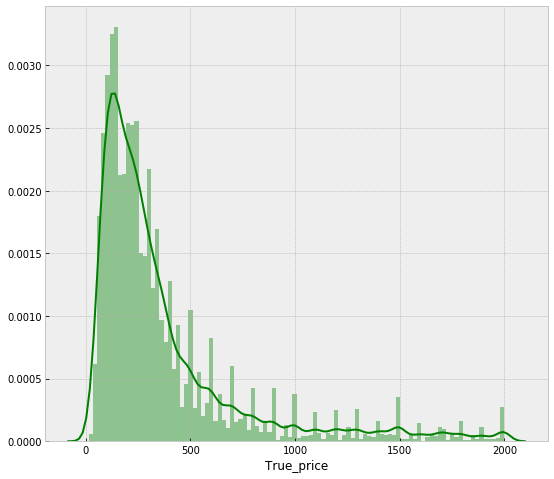

In [42]:
plt.figure(figsize=(9, 8))
sns.distplot(ndf['True_price'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [51]:
plt.figure(figsize=(20, 15))
#sns.distplot(df_1['price'], color='g', bins=100, hist_kws={'alpha': 0.4}, hue="type_id")
sns.displot(ndf, x='True_price', hue='type_id', multiple="stack", stat="density", palette="magma")

AttributeError: module 'seaborn' has no attribute 'displot'

<Figure size 1440x1080 with 0 Axes>

The plot above shows distribution by wine type. We se that all types have kind of the same right skewed density.

The following shows how the number of reviews are destiputed, the number are very scewed, as most wines have under 100 ratings
but the maximum number of ratings is 59660.

In [52]:
print(ndf['num_review'].describe())
a=len(ndf[(ndf['num_review'] <= 50)])
b=len(ndf[(ndf['num_review'] > 50) & (ndf['num_review'] <= 100)])
c=len(ndf[(ndf['num_review'] > 100) & (ndf['num_review'] <= 1000)])
d=len(ndf[(ndf['num_review'] > 1000)])
print('numer of vines with number of reviews under 50: ', a)
print('numer of vines with number of reviews between 50 and 100: ', b)
print('numer of vines with number of reviews between 100 and 1000: ', c)
print('numer of vines with number of reviews 0ver 1000: ', d)

count     13787.000000
mean        509.358381
std        2271.164918
min          25.000000
25%          53.000000
50%         122.000000
75%         337.000000
max      106981.000000
Name: num_review, dtype: float64
numer of vines with number of reviews under 50:  3202
numer of vines with number of reviews between 50 and 100:  2942
numer of vines with number of reviews between 100 and 1000:  6360
numer of vines with number of reviews 0ver 1000:  1283


In [53]:
#The following shows how the number of reviews that are destiputed. Number of reviews under 100.
data_few=ndf[(ndf['num_review'] <= 100)]
sns.displot(data_few, x="num_review", kind="kde")[0:1000]

AttributeError: module 'seaborn' has no attribute 'displot'

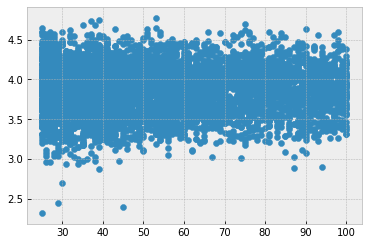

In [54]:
# data.num_review.plot()
plt.scatter(data_few['num_review'], data_few['Calculated rating'])

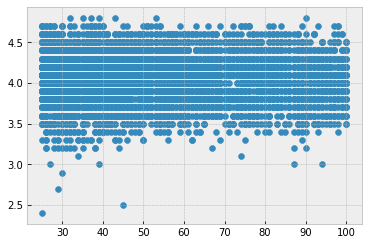

In [55]:
plt.scatter(data_few['num_review'], data_few['Rating'])

## Numeric data distribution
For this part lets look at the distribution of all of the features by ploting them

To do so lets first list all the types of our data from our dataset and take only the numerical ones:

In [56]:
list(set(ndf.dtypes.tolist()))

[dtype('float64'), dtype('int32'), dtype('O'), dtype('int64')]

In [59]:
ndf.head()

,Winery,Wine,Year,Rating,num_review,price,discounted_from,country,region,wine_id,...,two,three,four,five,True_price,Today,age,Calculated rating,rat_dev,alcohol_new
0,Rinforzo,Primitivo Salento,2019,4.5,NaN,129.0,179.0,Italien,Salento,1385662.0,...,NaN,NaN,NaN,NaN,179.0,2021,2,NaN,NaN,12.93592
1,Caballo Loco,Grand Cru Apalta,2018,4.5,NaN,141.5,249.0,Chile,Colchagua Valley,4837001.0,...,NaN,NaN,NaN,NaN,249.0,2021,3,NaN,NaN,12.93592
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,1484.0,149.0,NaN,Italien,Primitivo di Manduria,1202838.0,...,9.0,105.0,901.0,465.0,149.0,2021,4,4.222372,0.177628,14.50000
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,320.0,199.0,NaN,Italien,Isola dei Nuraghi,7365831.0,...,1.0,24.0,212.0,83.0,199.0,2021,4,4.178125,0.221875,12.93592
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,NaN,199.0,329.0,Italien,Amarone della Valpolicella,1103239.0,...,NaN,NaN,NaN,NaN,329.0,2021,4,NaN,NaN,12.93592


In [60]:
df_num = ndf.select_dtypes(include = ['float64', 'int64']).drop(['Today','one','two','three','four','five'],axis=1)
df_num.head()

,Rating,num_review,price,discounted_from,wine_id,type_id,updated_rating,alcohol,True_price,age,Calculated rating,rat_dev,alcohol_new
0,4.5,NaN,129.0,179.0,1385662.0,1.0,NaN,NaN,179.0,2,NaN,NaN,12.93592
1,4.5,NaN,141.5,249.0,4837001.0,1.0,NaN,NaN,249.0,3,NaN,NaN,12.93592
2,4.4,1484.0,149.0,NaN,1202838.0,1.0,4.4,14.5,149.0,4,4.222372,0.177628,14.50000
3,4.4,320.0,199.0,NaN,7365831.0,1.0,4.4,NaN,199.0,4,4.178125,0.221875,12.93592
4,4.4,NaN,199.0,329.0,1103239.0,1.0,NaN,NaN,329.0,4,NaN,NaN,12.93592


Now lets plot them all:

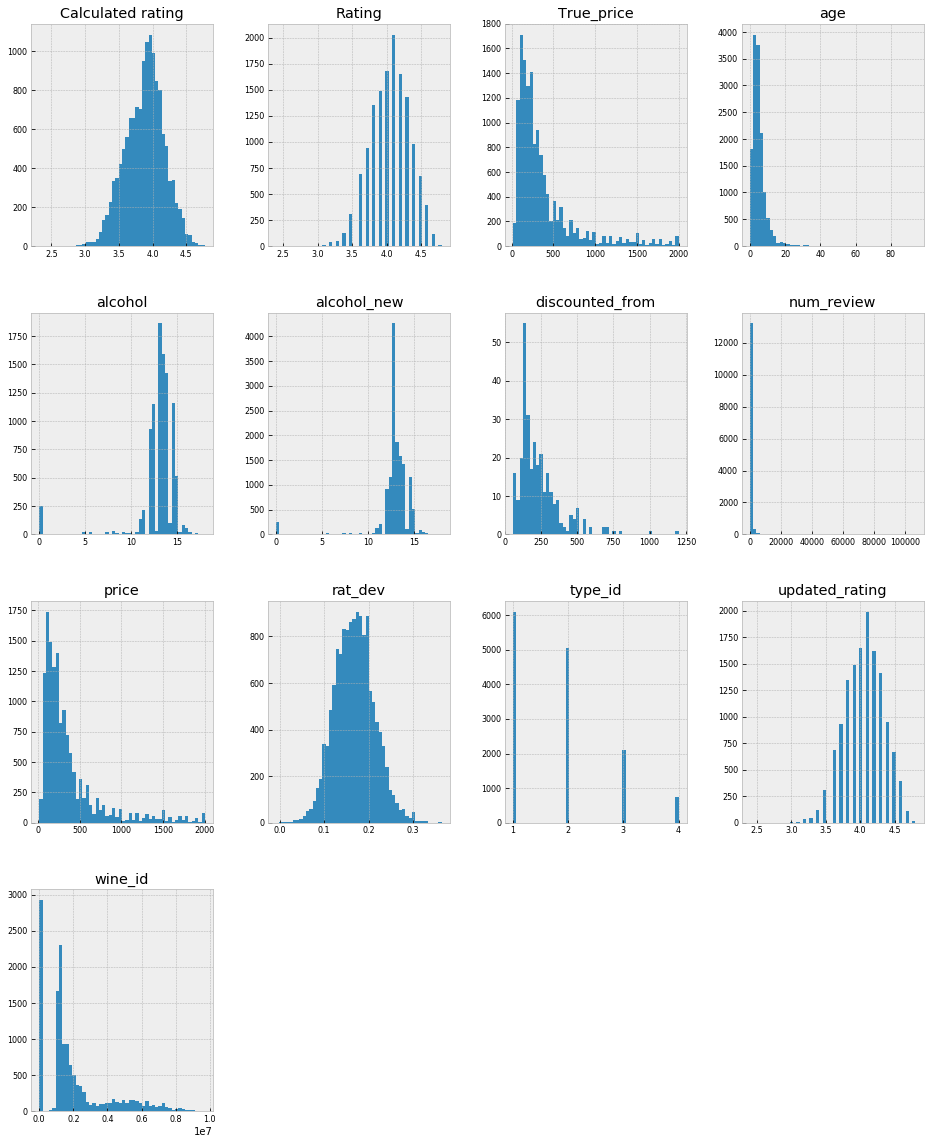

In [61]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

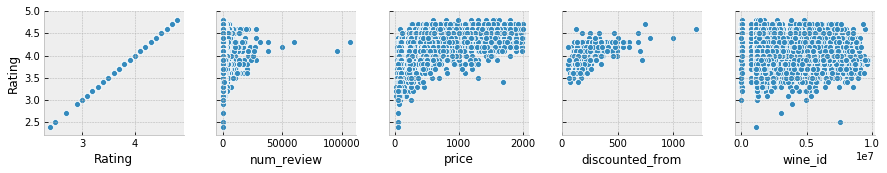

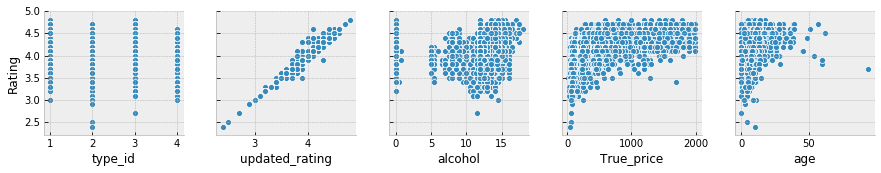

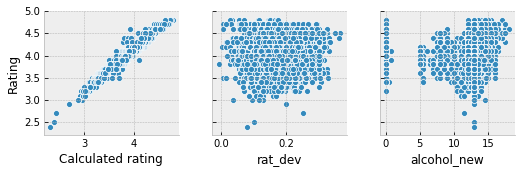

In [62]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Rating'])

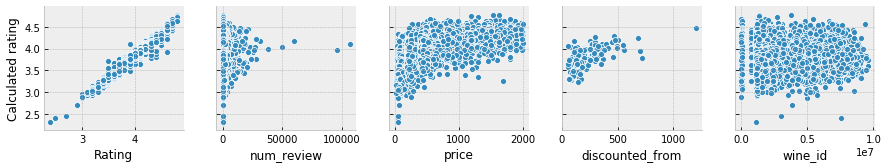

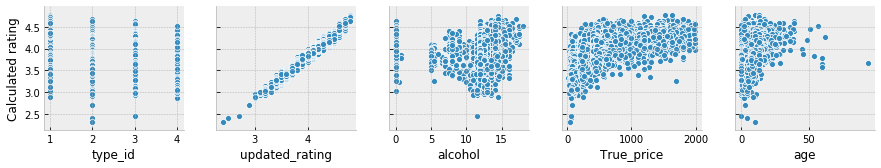

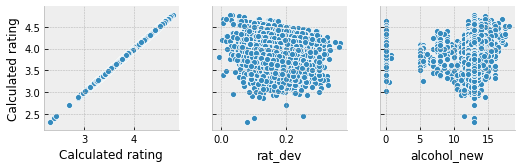

In [63]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Calculated rating'])

We can identify some relationships, but they are not very clear. Most of them seems to have a slight linear relationship with the Rating. We also notice that the number of reviews have one very big outlier, where there is more than 60000 reviews. But below ypu can se, that taking a closer look at the distribution of the category with under a 100 reviews, that the correlation does not get any clearer.

Take OpenPorchSF, I doubt that all houses have a porch (mine doesn't for instance but I don't lose hope that one day... yeah one day...).

Type_id is actually not numeric value, it indicates which type of wine we are looking at (see 'Scraping Vivino.dk - function David'), but we can see that type 1 (red) and type (4) rosé tends to get higher ratings than type 2 (white) and type 3 (sparkeling).

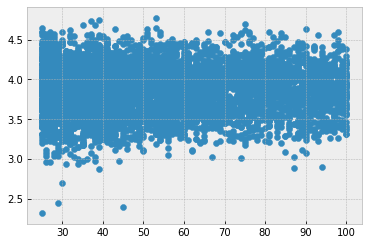

In [64]:
# data.num_review.plot()
plt.scatter(data_few['num_review'], data_few['Calculated rating'])

In [65]:
df_num_corr = df_num.corr()['Rating'][1:] # 1 because the first row is Rating
df_num_corr

num_review           0.027236
price                0.591721
discounted_from      0.528400
wine_id             -0.118314
type_id             -0.251009
updated_rating       0.997973
alcohol              0.109559
True_price           0.593156
age                  0.348877
Calculated rating    0.986413
rat_dev              0.144435
alcohol_new          0.090538
Name: Rating, dtype: float64

In [66]:
df_num_corr = df_num.corr()['Calculated rating'][:22] # 1 because the first row is Rating
df_num_corr

Rating               0.986413
num_review           0.033867
price                0.585022
discounted_from      0.586511
wine_id             -0.125058
type_id             -0.246324
updated_rating       0.987848
alcohol              0.106504
True_price           0.585176
age                  0.344481
Calculated rating    1.000000
rat_dev             -0.007161
alcohol_new          0.087986
Name: Calculated rating, dtype: float64

### Feature to feature relationship
Trying to plot all the numerical features in a seaborn pairplot will take us too much time and will be hard to interpret. We can try to see if some variables are linked between each other and then explain their relation with common sense.

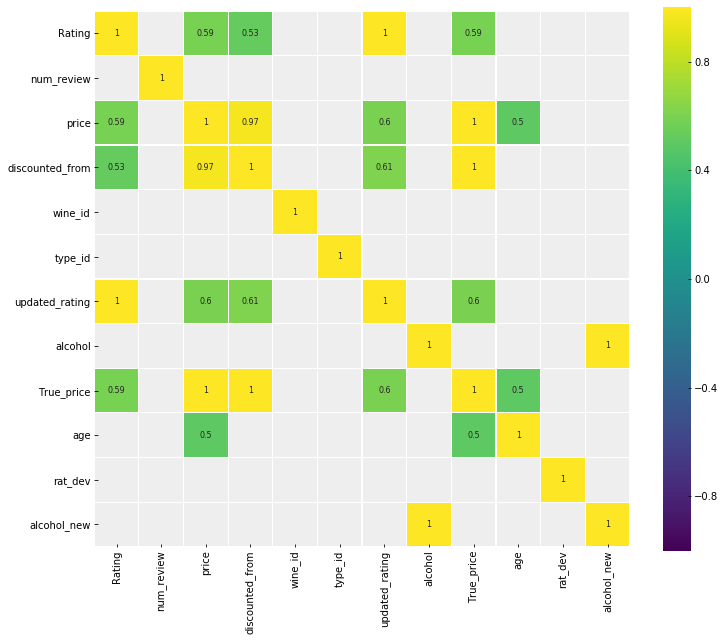

In [67]:
corr = df_num.drop('Calculated rating', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Saving the cuantitative

In [68]:
#Just saving the cuantitative
quantitative_features_list = ['num_review', 'price', 'discounted_from', 'type_id', 'Calculated rating','age']
df_quantitative_values = ndf[quantitative_features_list]
df_quantitative_values.head()

,num_review,price,discounted_from,type_id,Calculated rating,age
0,NaN,129.0,179.0,1.0,NaN,2
1,NaN,141.5,249.0,1.0,NaN,3
2,1484.0,149.0,NaN,1.0,4.222372,4
3,320.0,199.0,NaN,1.0,4.178125,4
4,NaN,199.0,329.0,1.0,NaN,4


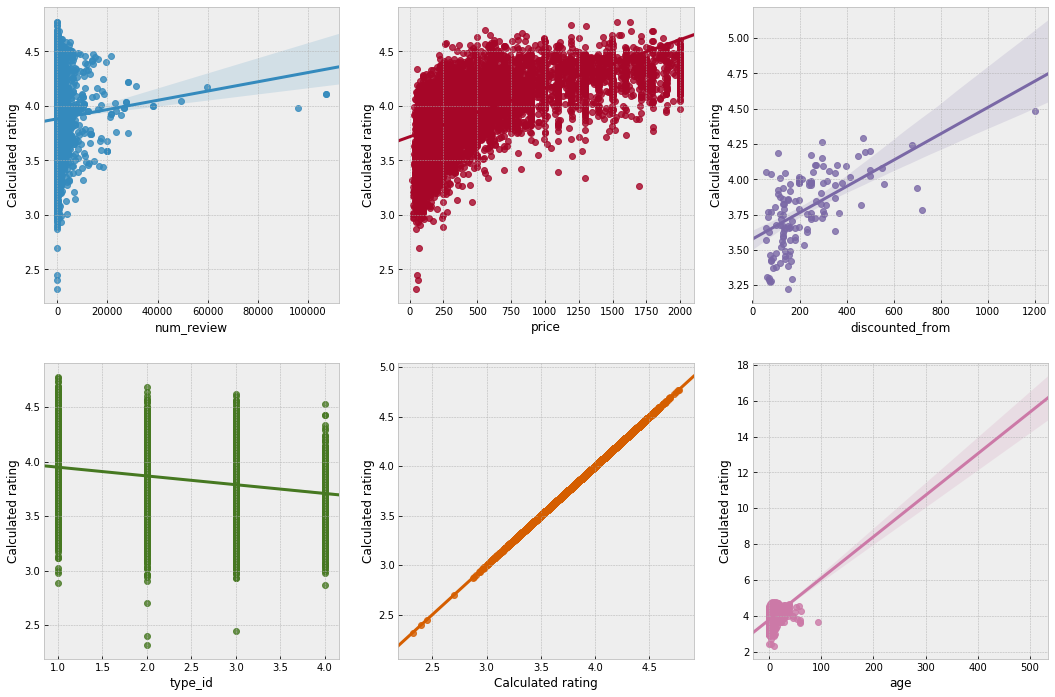

In [69]:
fig, ax = plt.subplots(round(len(quantitative_features_list) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(quantitative_features_list):
        sns.regplot(x=quantitative_features_list[i],y='Calculated rating', data=ndf[quantitative_features_list], ax=ax)

The figures above are not very pretty. because the correlation is not that clear.

## categorical variables

In [70]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + ndf.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in ndf.columns.tolist())]
df_categ = ndf[categorical_features]
df_categ.head()

,Winery,Wine,Year,Rating,country,region,wine_id,updated_rating,grapes_real,alcohol,one,two,three,four,five,True_price,Today,age,rat_dev,alcohol_new
0,Rinforzo,Primitivo Salento,2019,4.5,Italien,Salento,1385662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.0,2021,2,NaN,12.93592
1,Caballo Loco,Grand Cru Apalta,2018,4.5,Chile,Colchagua Valley,4837001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.0,2021,3,NaN,12.93592
2,Varvaglione,Papale Linea Oro Primitivo di Manduria,2017,4.4,Italien,Primitivo di Manduria,1202838.0,4.4,['Primitivo'],14.5,4.0,9.0,105.0,901.0,465.0,149.0,2021,4,0.177628,14.50000
3,Argiolas,Korem Bovale Isola dei Nuraghi,2017,4.4,Italien,Isola dei Nuraghi,7365831.0,4.4,['Bovale'],NaN,0.0,1.0,24.0,212.0,83.0,199.0,2021,4,0.221875,12.93592
4,Tinazzi,Ca' de' Rocchi Amarone della Valpolicella La B...,2017,4.4,Italien,Amarone della Valpolicella,1103239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.0,2021,4,NaN,12.93592


In [72]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))
df_not_num=df_not_num.drop(['Winery', 'Wine','region'], axis=1)
df_not_num.head()

There is 5 non numerical features including:
['Winery', 'Wine', 'country', 'region', 'grapes_real']


,country,grapes_real
0,Italien,NaN
1,Chile,NaN
2,Italien,['Primitivo']
3,Italien,['Bovale']
4,Italien,NaN


The code below looks at the categorical data for country

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]), <a list of 38 Text xticklabel objects>)

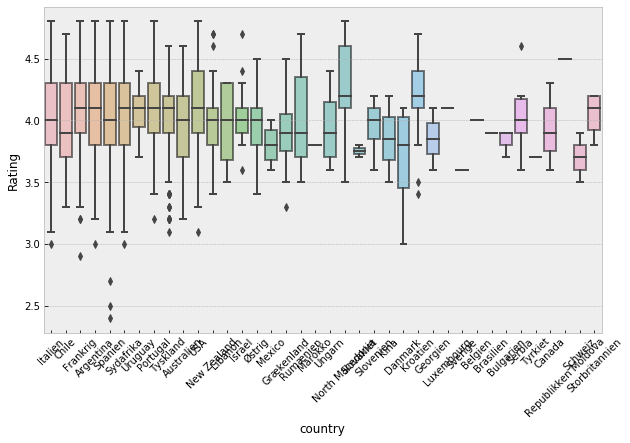

In [73]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='country', y='Rating', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [74]:
df_categ["country"].value_counts()

Frankrig               4948
Italien                3653
Spanien                1576
USA                     859
Tyskland                711
Sydafrika               506
Argentina               313
Portugal                303
New Zealand             279
Australien              236
Østrig                  210
Chile                   144
Kroatien                 59
Grækenland               27
Storbritannien           18
Ungarn                   15
Rumænien                 15
Uruguay                  15
Slovenien                14
North Macedonia          13
Israel                   13
Libanon                  12
Serbia                    6
Mexico                    4
Danmark                   4
Bulgarien                 3
Canada                    3
Schweiz                   2
Georgien                  2
Kina                      2
Slovakiet                 2
Sverige                   1
Luxembourg                1
Republikken Moldova       1
Belgien                   1
Marokko             

In [76]:
df_categ['Year'] = df_categ.Year.apply(str)
df_categ['Year'] = df_categ['Year'].str.strip().astype(str) #The year category needs to be stripped. 
df_categ["Year"].value_counts()

C:\Users\Victoria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Victoria\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2018    2334
2017    1957
2016    1808
2019    1616
2015    1323
2021    1162
2014     798
2020     653
2013     546
2012     454
2011     298
2010     224
2009     158
2008     144
2007      91
2006      88
2005      61
2004      50
2003      32
2002      28
2000      23
2001      22
1999      17
1998      14
1990       9
1993       9
1995       8
1989       7
1997       5
1985       4
1996       4
1983       4
1994       3
1961       3
1982       3
1992       3
1988       2
1972       1
1959       1
1964       1
1986       1
1976       1
1970       1
1967       1
1975       1
1927       1
Name: Year, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 46 Text xticklabel objects>)

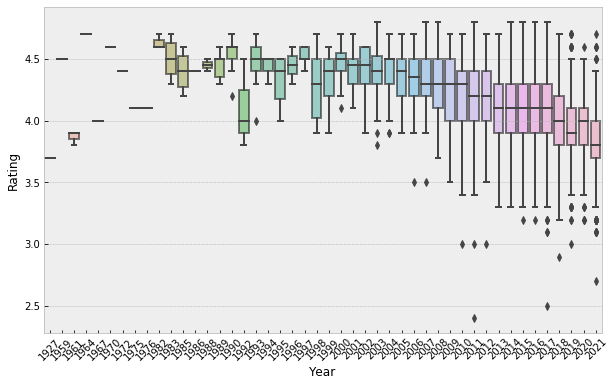

In [77]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Year', y='Rating', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

The following plots show the distribution between the different catcories in the tree nin numeric categories Year, country and grapetype. 

In [78]:
ndf.to_csv('df.csv') #saving the data

## Investigating Winery and Name
### Winery:

In [79]:
df_categ['Winery'].value_counts() #['Winery', 'Wine','region']

Domaine de la Vougeraie                  91
E. Guigal                                69
Domaine Henri Boillot                    59
Louis Jadot                              58
La Spinetta                              55
Gaja                                     55
Antinori                                 52
Terlan (Terlano)                         51
Kistler                                  49
Domaine Zind Humbrecht                   48
Domaine Marquis d'Angerville             46
Mullineux                                43
Telmo Rodriguez                          41
Bouchard Père & Fils                     40
Gramona                                  40
Henri Bourgeois                          37
Catena Zapata                            37
Dr. Bürklin-Wolf                         36
Domaine Rostaing                         35
Domaine Weinbach                         35
Louis Latour                             33
Passopisciaro                            33
Two Hands                       

In [80]:
df_winery=df_categ['Winery'].str.strip()
df_winery.value_counts()

Domaine de la Vougeraie                  91
E. Guigal                                69
Domaine Henri Boillot                    59
Louis Jadot                              58
La Spinetta                              55
Gaja                                     55
Antinori                                 52
Terlan (Terlano)                         51
Kistler                                  49
Domaine Zind Humbrecht                   48
Domaine Marquis d'Angerville             46
Mullineux                                43
Telmo Rodriguez                          41
Bouchard Père & Fils                     40
Gramona                                  40
Henri Bourgeois                          37
Catena Zapata                            37
Dr. Bürklin-Wolf                         36
Domaine Rostaing                         35
Domaine Weinbach                         35
Louis Latour                             33
Passopisciaro                            33
Two Hands                       

### Wine:

In [81]:
df_categ['Wine'].value_counts() #['Winery', 'Wine','region']

Chardonnay                                           164
Sauvignon Blanc                                      111
Brunello di Montalcino                                98
Cabernet Sauvignon                                    84
Pinot Noir                                            82
Rosé                                                  57
Pomerol                                               51
Châteauneuf-du-Pape                                   51
Pauillac (Grand Cru Classé)                           44
Barolo                                                44
Riesling                                              33
Saint-Émilion Grand Cru                               33
Barbaresco                                            32
Chablis                                               31
Syrah                                                 31
Amarone della Valpolicella Classico                   31
Saint-Julien (Grand Cru Classé)                       30
Bourgogne Chardonnay           

In [82]:
df_wine=df_categ['Wine'].str.strip()
df_wine.value_counts()

Chardonnay                                           165
Sauvignon Blanc                                      111
Brunello di Montalcino                                98
Cabernet Sauvignon                                    85
Pinot Noir                                            82
Rosé                                                  57
Pomerol                                               51
Châteauneuf-du-Pape                                   51
Pauillac (Grand Cru Classé)                           44
Barolo                                                44
Saint-Émilion Grand Cru                               33
Riesling                                              33
Amarone della Valpolicella Classico                   32
Barbaresco                                            32
Chablis                                               31
Syrah                                                 31
Bourgogne Chardonnay                                  30
Saint-Julien (Grand Cru Classé)

### Region:

In [83]:
df_categ['region'].value_counts() #['Winery', 'Wine','region']

Champagne                                          605
Toscana                                            326
Barolo                                             254
Rioja                                              233
Cava                                               232
Südtirol - Alto Adige                              226
Pfalz                                              225
Ribera del Duero                                   214
Châteauneuf-du-Pape                                197
Brunello di Montalcino                             179
Alsace                                             169
Napa Valley                                        160
Stellenbosch                                       158
Marlborough                                        154
Sancerre                                           150
Franciacorta                                       144
Mendoza                                            143
Mosel                                              142
Bourgogne 

In [84]:
df_categ['grapes_real'].value_counts()

['Chardonnay']                                                                                   2018
['Pinot Noir']                                                                                   1032
['Riesling']                                                                                      711
['Sauvignon Blanc']                                                                               591
['Cabernet Sauvignon']                                                                            479
['Sangiovese']                                                                                    440
['Nebbiolo']                                                                                      440
['Shiraz/Syrah']                                                                                  435
['Tempranillo']                                                                                   328
['Chardonnay', 'Pinot Noir']                                                      

In [85]:
df_wine=df_categ['region'].str.strip()
df_wine.value_counts()

Champagne                                          605
Toscana                                            326
Barolo                                             254
Rioja                                              233
Cava                                               232
Südtirol - Alto Adige                              226
Pfalz                                              225
Ribera del Duero                                   214
Châteauneuf-du-Pape                                197
Brunello di Montalcino                             179
Alsace                                             169
Napa Valley                                        160
Stellenbosch                                       158
Marlborough                                        154
Sancerre                                           150
Franciacorta                                       144
Mendoza                                            143
Mosel                                              142
Bourgogne 

# Descriptive Statistics
## Summary table
In this part of the notebook, we created a dataframe that will be used in the paper to do the descriptive statistics part, we did a dataframe that is by country 

### Pie Chart 
this part makes the pie chart of the number of wines produced per country captured by Vivino

In [86]:
summary1=pd.DataFrame({'Wines' : ndf.groupby('country')["Wine"].count(), 
                       'Winery' : ndf.groupby('country')["Winery"].nunique(),
                       'Average Rating' : ndf.groupby('country')["Rating"].mean(),
                       'Average Price' : ndf.groupby('country')["True_price"].mean()})
summary2 = ndf.groupby(['country'])[['num_review']].sum() #this was hard to put inside so we made it separete
summary3 = pd.merge(summary1, summary2, on='country') #merging
summary4 = summary3.copy() #copying the df for later create the table and summary 3 is for the pie chart
summary3.reset_index(level=0, inplace=True) #index cause problem so we reset
summary3['World weight'] = (summary3['Wines'] * 100) / 35637 #getting the percentage of wines per country
summary3 = summary3.round(decimals=2) #round to look better
summary3 = summary3.astype({"Wines": int, "Winery": int, "num_review": int}) #this columns generated problems so we change to int
summary3 = summary3.rename(columns={'country': 'Country', 'num_review': 'Wine Review'})
summary3 = summary3.sort_values('World weight', ascending = False)
summary3.to_csv(f'summary.csv')
summary3_1 = summary3[:10].copy() #creating the others column so the pie chart doesnt catch a lot of countries that doesnt really have a weight
new_row = pd.DataFrame(data = {
    'Country' : ['others'],
    'World weight' : [summary3['World weight'][10:].sum()]
})
summary3_1 = pd.concat([summary3_1, new_row]) #concat

C:\Users\Victoria\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [87]:
summary3_1

,Average Price,Average Rating,Country,Wine Review,Winery,Wines,World weight
8,474.77,4.08,Frankrig,2841467.0,1432.0,4948.0,13.88
12,315.35,4.04,Italien,1705659.0,1092.0,3653.0,10.25
28,271.47,4.00,Spanien,898702.0,509.0,1576.0,4.42
34,565.94,4.12,USA,472287.0,286.0,859.0,2.41
33,263.17,4.03,Tyskland,98740.0,161.0,711.0,2.00
31,248.66,4.05,Sydafrika,136558.0,156.0,506.0,1.42
0,331.43,4.08,Argentina,327050.0,66.0,313.0,0.88
21,253.52,4.12,Portugal,152584.0,111.0,303.0,0.85
19,230.39,3.97,New Zealand,152044.0,93.0,279.0,0.78
1,337.47,3.98,Australien,51632.0,78.0,236.0,0.66


As we can se above we have our df just includind the top ten so the pies chart looks nicer

In [88]:
labels = summary3['Country']
sizes = summary3['World weight']

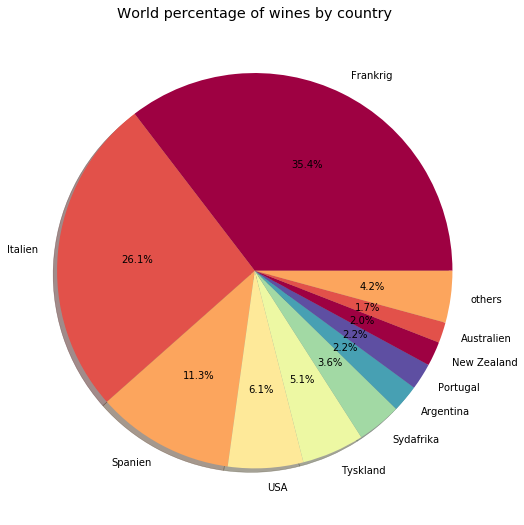

In [89]:
rating_labels = summary3_1['Country']
rating_counts = summary3_1['World weight']
plt.figure(1, figsize=(40,20))
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(the_grid[0, 1], aspect=1, title='World percentage of wines by country')
type_show_ids = plt.pie(rating_counts, labels=rating_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.savefig('piechart.png', bbox_inches='tight')

### Summary table
In this part we use the complete table, droping of the part of the top ten wines, in order to create a summary table describing each country wines, winery, average rating, average price and number of reviews per country

In [90]:
summary4.loc["Total / Average"] = summary4.sum()
summary4.loc['Total / Average', 'Average Rating'] = summary4.loc['Total / Average', 'Average Rating'] / (len(summary4) - 1)
summary4.loc['Total / Average', 'Average Price'] = summary4.loc['Total / Average', 'Average Price'] / (len(summary4) - 1)
summary4 = summary4.round(decimals=2)
summary4.reset_index(level=0, inplace=True)
summary4 = summary4.rename(columns={'country': 'Country', 'num_review': 'Wine Review'})
summary4 = summary4.astype({"Wines": int, "Winery": int, "Wine Review": int})
summary4.drop(summary4[summary4['Wines'] < 50].index, inplace = True)

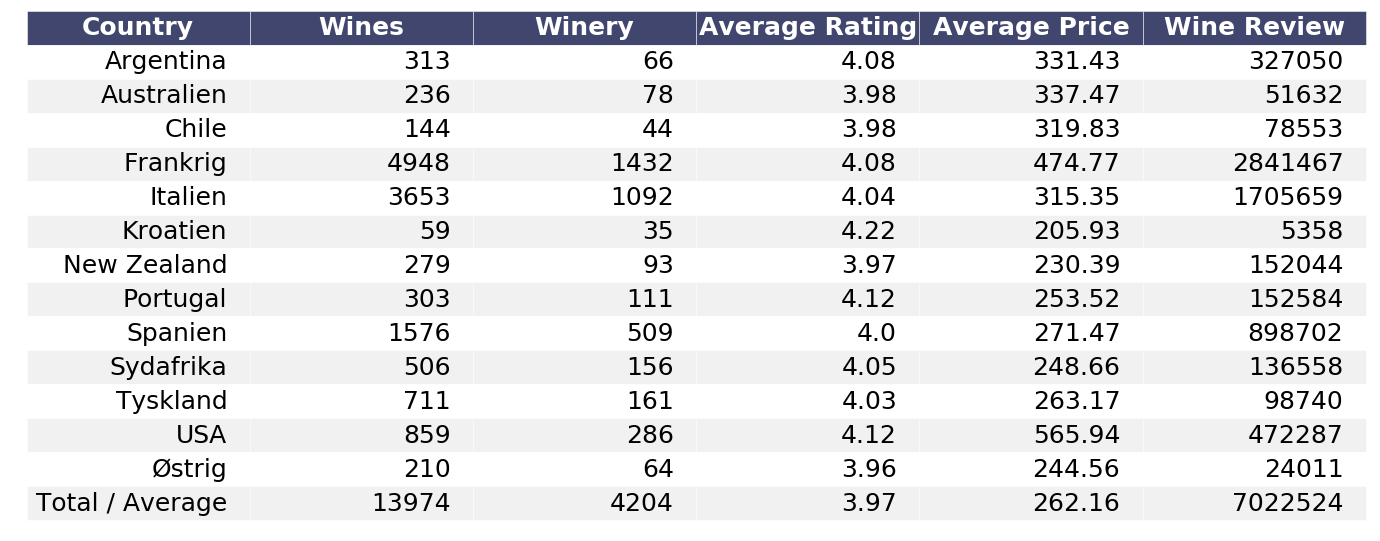

In [91]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=25,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(summary4, header_columns=0, col_width=4.0)
plt.savefig('mytable.png')

### Correlation between ratings and price

Making the correlation plot for the main paper

C:\Users\Victoria\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


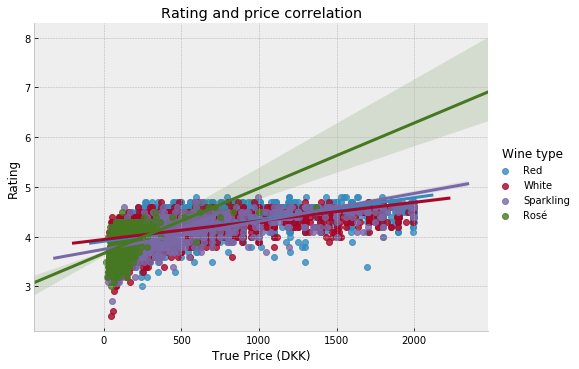

In [92]:
plotdf = ndf.copy()
plotdf.loc[plotdf['type_id'] == 1.0, 'type_id'] = 'Red'
plotdf.loc[plotdf['type_id'] == 2.0, 'type_id'] = 'White'
plotdf.loc[plotdf['type_id'] == 3.0, 'type_id'] = 'Sparkling'
plotdf.loc[plotdf['type_id'] == 4.0, 'type_id'] = 'Rosé'
plotdf.rename(columns={'type_id':'Wine type'}, inplace=True)
#df.loc[df['First Season'] > 1990, 'First Season'] = 1
ax = sns.lmplot(x='True_price', y='Rating', hue='Wine type', data=plotdf, size=5, aspect=1.4, legend=True) 
ax.set(xlabel='True Price (DKK)', ylabel='Rating')
#ax = plt.gca()
plt.title("Rating and price correlation")
plt.savefig('rating price corr.png')

# Manual grape dummies

1. The grapes are strings so they first have to be converted back to list type object
2. creating the dummies

In [93]:
#Loading the dataset
df=pd.read_csv("df_for_ML.csv")
print(len(df))
df.head()

13611


,Unnamed: 0,Wine,Rating,num_review,country,type_id,grapes_real,True_price,age,alcohol_new
0,2,Papale Linea Oro Primitivo di Manduria,4.4,1484.0,Italien,1.0,['Primitivo'],149.0,4,14.50000
1,3,Korem Bovale Isola dei Nuraghi,4.4,320.0,Italien,1.0,['Bovale'],199.0,4,12.93592
2,7,Edizione Cinque Autoctoni,4.4,52.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",149.0,1,12.93592
3,8,Langhe Rosso,4.4,35.0,Italien,1.0,['Nebbiolo'],140.0,1,12.93592
4,9,Edizione Cinque Autoctoni,4.3,59716.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",249.0,0,14.00000


In [94]:
df.isnull().sum()

Unnamed: 0     0
Wine           0
Rating         0
num_review     0
country        0
type_id        0
grapes_real    0
True_price     0
age            0
alcohol_new    0
dtype: int64

# 1 Converting the string list to a list

In [95]:
#Testing for converting the string list to a list
single=df["grapes_real"][2]

print(type(single))
print(single)
single=single.replace("]","").replace("[","").replace("'","").split(', ')
print(type(single))
single

<class 'str'>
['Sangiovese', 'Montepulciano', 'Primitivo', 'Malvasia Nera']
<class 'list'>


['Sangiovese', 'Montepulciano', 'Primitivo', 'Malvasia Nera']

In [96]:
#Same but with a wine with more than one grape
second=df["grapes_real"][7]

print(type(second))
print(second)
second=second.replace("]","").replace("[","").replace("'","").split(', ')
print(type(second))
second

<class 'str'>
['Cabernet Sauvignon', 'Merlot', 'Sangiovese']
<class 'list'>


['Cabernet Sauvignon', 'Merlot', 'Sangiovese']

In [97]:
#Okay.. Now that we have all the needed tools, let's begin converting the column to a list.
grape_l=[]

for grapes in df["grapes_real"]:
    gg=grapes.replace("]","").replace("[","").replace("'","").replace('"',"").strip().split(', ')
    grape_l.append(gg)
print(type(grape_l))
print(len(grape_l))
df["grapes"]=grape_l

df["grapes"]

<class 'list'>
13611


0                                              [Primitivo]
1                                                 [Bovale]
2        [Sangiovese, Montepulciano, Primitivo, Malvasi...
3                                               [Nebbiolo]
4        [Sangiovese, Montepulciano, Primitivo, Malvasi...
5                                                 [Malbec]
6                [Merlot, Nero dAvola, Cabernet Sauvignon]
7                 [Cabernet Sauvignon, Merlot, Sangiovese]
8                                              [Aglianico]
9                 [Cabernet Sauvignon, Merlot, Sangiovese]
10                                             [Primitivo]
11                                             [Primitivo]
12                        [Cabernet Sauvignon, Tinto Fino]
13                                                [Malbec]
14        [Shiraz/Syrah, Merlot, Sangiovese, Petit Verdot]
15              [Croatina, Corvinone, Corvina, Rondinella]
16                                             [Primitiv

In [98]:
grape_dummies=pd.get_dummies(df["grapes"].apply(pd.Series).stack()).sum(level=0)

In [114]:
grape_dummies.head()

,,Agiorgitiko,Aglianico,Airen,Albarin Blanco,Albariño,Albarola,Albillo,Albillo Mayor,Alfrocheiro Preto,...,Viosinho,Vitovska,Viura,Weissburgunder,Welschriesling,Xarel-lo,Zibibbo,Zierfandler,Zinfandel,Zweigelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
df3=pd.concat([grape_dummies, df],axis=1)

df3.head()

,,Agiorgitiko,Aglianico,Airen,Albarin Blanco,Albariño,Albarola,Albillo,Albillo Mayor,Alfrocheiro Preto,...,Wine,Rating,num_review,country,type_id,grapes_real,True_price,age,alcohol_new,grapes
0,0,0,0,0,0,0,0,0,0,0,...,Papale Linea Oro Primitivo di Manduria,4.4,1484.0,Italien,1.0,['Primitivo'],149.0,4,14.50000,[Primitivo]
1,0,0,0,0,0,0,0,0,0,0,...,Korem Bovale Isola dei Nuraghi,4.4,320.0,Italien,1.0,['Bovale'],199.0,4,12.93592,[Bovale]
2,0,0,0,0,0,0,0,0,0,0,...,Edizione Cinque Autoctoni,4.4,52.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",149.0,1,12.93592,"[Sangiovese, Montepulciano, Primitivo, Malvasi..."
3,0,0,0,0,0,0,0,0,0,0,...,Langhe Rosso,4.4,35.0,Italien,1.0,['Nebbiolo'],140.0,1,12.93592,[Nebbiolo]
4,0,0,0,0,0,0,0,0,0,0,...,Edizione Cinque Autoctoni,4.3,59716.0,Italien,1.0,"['Sangiovese', 'Montepulciano', 'Primitivo', '...",249.0,0,14.00000,"[Sangiovese, Montepulciano, Primitivo, Malvasi..."


In [ ]:
df3.to_csv("data_with_grape_dummies.csv")

# MACHINE LEARNING

This document contains the following.

Lasso 2 deg
1. Make pipeline
2. Use K-fold to find optimal hyperparameter
    Remember to save
3. Make pipeline with optimal hyperparameter
4. Fit model
5. Save mean squared error and root mean squared error

Lasso 3 deg
1. Make pipeline
2. Use K-fold to find optimal hyperparameter
    Remember to save
3. Make pipeline with optimal hyperparameter
4. Fit model
5. Save mean squared error and root mean squared error

Ridge 2 deg 
1. Make pipeline
2. Use K-fold to find optimal hyperparameter
    Remember to save
3. Make pipeline with optimal hyperparameter
4. Fit model
5. Save mean squared error and root mean squared error

Ridge 3 deg 
1. Make pipeline
2. Use K-fold to find optimal hyperparameter
    Remember to save
3. Make pipeline with optimal hyperparameter
4. Fit model
5. Save mean squared error and root mean squared error


Compare results.
Show the hyperparameters in a table.
Show MSE, RMSE and MAE in a table.
Find the best model based on errors. 
- Make a plot of the predicted values of our model against the actual values of the test data.
- Learning curve 
- Validation curve


We use 10 fold: https://machinelearningmastery.com/k-fold-cross-validation/


In [102]:
# #Importing data
# data=pd.read_csv('Data_c_no_dups.csv')
# data=data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'discounted_from', 'price', 'Year', 'Winery', 'Grapetype', 'Today', 'region'],axis=1) 
# #We don't use these vairables in our final model
# data

#Importing data
data=pd.read_csv('data_with_grape_dummies.csv')
data=data.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1' ],axis=1) 
#We don't use these vairables in our final model

## Creating dummies 

In [103]:
# data["type_id_cat"]=data["type_id"].astype("category").astype(str) #Turning wine type into a categorical variable.

# type_dum=pd.get_dummies(data["type_id_cat"]) #Creating dummies for wine type.
# # region_dum=pd.get_dummies(data["region"]) #Creating dummies for region.The file is too big, when there is also dummies for country
# country_dum=pd.get_dummies(data["country"])  #Creating dummies for country.

# df = pd.concat([data, type_dum, country_dum], axis=1) #Concatenating the data with the dummy variables


data["type_id_cat"]=data["type_id"].astype("category").astype(str) #Turning wine type into a categorical variable.

type_dum=pd.get_dummies(data["type_id_cat"]) #Creating dummies for wine type.
# region_dum=pd.get_dummies(data["region"]) #Creating dummies for region.The file is too big, when there is also dummies for country
country_dum=pd.get_dummies(data["country"])  #Creating dummies for country.

df = pd.concat([data, type_dum, country_dum], axis=1) #Concatenating the data with the dummy variables

In [104]:
#We drop the variables that we have turned into dummies.
df=df.drop(['type_id', 'country', 'type_id_cat', 'grapes_real', 'grapes'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Columns: 432 entries, Agiorgitiko to Østrig
dtypes: float64(4), int64(410), object(1), uint8(17)
memory usage: 43.3+ MB


In [105]:
df.info()
df.select_dtypes(include=['float64'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Columns: 432 entries, Agiorgitiko to Østrig
dtypes: float64(4), int64(410), object(1), uint8(17)
memory usage: 43.3+ MB


,Rating,num_review,True_price,alcohol_new
0,4.4,1484.0,149.000000,14.50000
1,4.4,320.0,199.000000,12.93592
2,4.4,52.0,149.000000,12.93592
3,4.4,35.0,140.000000,12.93592
4,4.3,59716.0,249.000000,14.00000
5,4.3,3559.0,359.950000,13.50000
6,4.3,1452.0,109.000000,13.50000
7,4.3,1057.0,183.333333,12.93592
8,4.3,815.0,149.950000,14.00000
9,4.3,498.0,149.000000,14.00000


## Seperating data into features and dependent variables

In [106]:
#Seperating data into features and dependent variables
X= df.drop(['Wine', 'Rating'],axis=1)
y= df['Rating'].astype(float)

In [110]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Columns: 430 entries, Agiorgitiko to Østrig
dtypes: float64(3), int64(410), uint8(17)
memory usage: 43.1 MB


 ## LASSO

## Lasso regression 2 degrees

In [111]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [113]:
# Cross Validation 
# K fold
# SETUP
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-4, 4, 66) 
# Outer loop: lambdas
mseCV = []
for lambda_ in tqdm.tqdm(lambdas):    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=2)),
                                    [0,1]),
                                    ('','passthrough', [i for i in range(2, X.shape[1])])]),
                                    Lasso(alpha=lambda_, random_state=161193))                
        X_train, y_train = X_dev.iloc[list(train_idx)], y_dev.iloc[list(train_idx)]
        X_val, y_val = X_dev.iloc[list(val_idx)], y_dev.iloc[list(val_idx)]
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
LAS_2_opt_lambda=lambdaCV.mean(axis=1).nsmallest(1)
print('Optimal lambda:', optimal_lambda.index[0])
print('Validation MSE: %.3f' % optimal_lambda.values[0])


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [02:18<00:00,  1.81s/it]


Optimal lambda: 0.0001
Validation MSE: 0.048


In [ ]:
#Used for making validation curve
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_r_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')  

In [ ]:
#Plotting validation curve
ax = mse_r_score.plot(logx=True, logy=True, figsize=(12,7))
ax = plt.gca()
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_title('Validation Curve')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.savefig('validationcurve.png', bbox_inches='tight') 

In [ ]:
# RETRAIN/RE-ESTIMATE MODEL USING OPTIMAL
pipe_lassoCV = make_pipeline(ColumnTransformer([('Continous', make_pipeline(StandardScaler(), PolynomialFeatures(degree=2)),
                                                 [0,1]),('','passthrough', [i for i in range(2, X.shape[1])])]), 
                             Lasso(alpha=0.0001, random_state=161193))
pipe_lassoCV.fit(X_dev, y_dev) 
LAS_2_mse=mse(pipe_lassoCV.predict(X_test),y_test)
LAS_2_rmse=mse(pipe_lassoCV.predict(X_test),y_test, squared=False)
LAS_2_mae=mae(pipe_lassoCV.predict(X_test),y_test)

In [ ]:
#Error measures for later use
print('LASSO 2 degrees: MSE=', LAS_2_mse, 'RMSE=', LAS_2_rmse, 'MAE=',LAS_2_mae)

In [ ]:
#Setup for plotting learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.0, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

In [ ]:
#Plotting learning curve 
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()
# ax.set_xlim(2000, 5000)
# ax.set_ylim(1.4*10**(-1), 1.8*10**(-1))

## Lasso regression 3 degrees



In [ ]:
#Seperating data into features and dependent variables
X= df.drop(['Wine', 'Rating'],axis=1)
y= df['Rating'].astype(float)

In [ ]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [ ]:
# Cross Validation 
# K fold
# SETUP
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-4, 4, 66) 
# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        
        pipe_lassoCV_3 = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=3)),
                                    [0,1]),
                                    ('','passthrough', [i for i in range(2, X.shape[1])])]),
                                    Lasso(alpha=lambda_, random_state=161193))          
        X_train, y_train = X_dev.iloc[list(train_idx)], y_dev.iloc[list(train_idx)]
        X_val, y_val = X_dev.iloc[list(val_idx)], y_dev.iloc[list(val_idx)]
        pipe_lassoCV_3.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV_3.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)

LAS_3_opt_lambda=lambdaCV.mean(axis=1).nsmallest(1)
print('Optimal lambda:', LAS_3_opt_lambda.index[0])
print('Validation MSE: %.3f' % LAS_3_opt_lambda.values[0])

In [ ]:
#Creating validation curve
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV_3,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_r_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda') 

In [ ]:
#Plotting validation curve
ax = mse_r_score.plot(logx=True, logy=True, figsize=(12,7))
ax = plt.gca()
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_title('Validation Curve')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.savefig('validationcurve.png', bbox_inches='tight') 

In [ ]:
#Make pipeline with optimal lambda
pipe_lassoCV_3 = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=3)),
                                    [0,1]), 
                                    ("", 'passthrough', [i for i in range(2, X.shape[1])])]),
                                    Lasso(alpha=0.0001, random_state=161193))
# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA
pipe_lassoCV_3.fit(X_dev, y_dev) 
LAS_3_mse=mse(pipe_lassoCV_3.predict(X_test),y_test)
LAS_3_rmse=mse(pipe_lassoCV_3.predict(X_test),y_test, squared=False)
LAS_3_mae=mae(pipe_lassoCV_3.predict(X_test),y_test)

https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge


In [ ]:
#Save error measures for later
print('LASSO 3 degrees: MSE=', LAS_3_mse, 'RMSE=', LAS_3_rmse, 'MAE=',LAS_3_mae)

In [ ]:
#Setup for learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV_3,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.0, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

In [ ]:
#Plotting learning curve
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()
# ax.set_xlim(2000, 5000)
# ax.set_ylim(1.4*10**(-1), 1.8*10**(-1))

## RIDGE

## Ridge regression 2 degrees

In [ ]:
#Seperating data into features and dependent variables
X= df.drop(['Wine', 'Rating'],axis=1)
y= df['Rating'].astype(float)

In [ ]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [ ]:
# Cross Validation 
# K fold
# SETUP
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-4, 4, 66) 
# Outer loop: lambdas
mseCVridge = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCVridge_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=2)),
                                    [0,1]),
                                    ('','passthrough', [i for i in range(2, X.shape[1])])]),
                                    Ridge(alpha=lambda_, random_state=161193))                
        X_train, y_train = X_dev.iloc[list(train_idx)], y_dev.iloc[list(train_idx)]
        X_val, y_val = X_dev.iloc[list(val_idx)], y_dev.iloc[list(val_idx)]
        pipe_ridgeCV.fit(X_train, y_train)        
        mseCVridge_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # Store result    
    mseCVridge.append(mseCVridge_) 
    
# Convert to DataFrame
lambdaCVridge = pd.DataFrame(mseCVridge, index=lambdas)
optimal_lambdaridge = lambdaCVridge.mean(axis=1).nsmallest(1)

rid_2_opt_lambda=lambdaCVridge.mean(axis=1).nsmallest(1)
print('Optimal lambda:', optimal_lambdaridge.index[0])
print('Validation MSE: %.3f' % optimal_lambdaridge.values[0])


In [ ]:
#Creating validation curve
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_ridgeCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_r_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda') 

In [ ]:
#Plotting validation curve
ax = mse_r_score.plot(logx=True, logy=True, figsize=(12,7))
ax = plt.gca()
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_title('Validation Curve')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.savefig('validationcurve.png', bbox_inches='tight') 

In [ ]:
#Make pipeline with optimal lambda
pipe_ridgeCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=2)),
                                    [0,1]), 
                                    ("", 'passthrough', [i for i in range(2, X.shape[1])])]),
                                    Ridge(alpha=11.121256211835888, random_state=161193))
# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA
pipe_ridgeCV.fit(X_dev, y_dev) 
RID_2_mse=mse(pipe_ridgeCV.predict(X_test),y_test)
RID_2_rmse=mse(pipe_ridgeCV.predict(X_test),y_test, squared=False)
RID_2_mae=mae(pipe_ridgeCV.predict(X_test),y_test)

In [ ]:
#Save error measures for later
print('Ridge 2 degrees: MSE=', RID_2_mse, 'RMSE=', RID_2_rmse, 'MAE=',RID_2_mae)

In [ ]:
#Setup for learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_ridgeCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.0, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

In [ ]:
#Plotting learning curve
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()
# ax.set_xlim(2000, 5000)
# ax.set_ylim(1.4*10**(-1), 1.8*10**(-1))

## Ridge regression 3 degrees

In [ ]:
#Seperating data into features and dependent variables
X= df.drop(['Wine', 'Rating'],axis=1)
y= df['Rating'].astype(float)

In [ ]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [ ]:
# Cross Validation 
# K fold
# SETUP
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-4, 4, 66) 
# Outer loop: lambdas
mseCVridge_3 = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCVridge_3_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_ridgeCV_3 = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=3)),
                                    [0,1]),
                                    ('','passthrough', [i for i in range(2, X.shape[1])])]),
                                    Ridge(alpha=lambda_, random_state=161193))                
        X_train, y_train = X_dev.iloc[list(train_idx)], y_dev.iloc[list(train_idx)]
        X_val, y_val = X_dev.iloc[list(val_idx)], y_dev.iloc[list(val_idx)]
        pipe_ridgeCV_3.fit(X_train, y_train)        
        mseCVridge_3_.append(mse(pipe_ridgeCV_3.predict(X_val), y_val))    
        
    # Store result    
    mseCVridge_3.append(mseCVridge_3_) 
    
# Convert to DataFrame
lambdaCVridge_3 = pd.DataFrame(mseCVridge_3, index=lambdas)
optimal_lambdaridge_3 = lambdaCVridge_3.mean(axis=1).nsmallest(1)

rid_3_opt_lambda=lambdaCVridge_3.mean(axis=1).nsmallest(1)
print('Optimal lambda:', optimal_lambdaridge_3.index[0])
print('Validation MSE: %.3f' % optimal_lambdaridge_3.values[0])


In [ ]:
#Creating validation curve
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_ridgeCV_3,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_r_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda') 

In [ ]:
#Plotting validation curve
ax = mse_r_score.plot(logx=True, logy=True, figsize=(12,7))
ax = plt.gca()
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_title('Validation Curve')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.savefig('validationcurve.png', bbox_inches='tight') 

In [ ]:
#Make pipeline with optimal lambda
pipe_ridgeCV_3 = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures(degree=3)),
                                    [0,1]), 
                                    ("", 'passthrough', [i for i in range(2, X.shape[1])])]),
                                    Ridge(alpha=11.121256211835888, random_state=161193))
# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA
pipe_ridgeCV_3.fit(X_dev, y_dev) 
RID_3_mse=mse(pipe_ridgeCV_3.predict(X_test),y_test)
RID_3_rmse=mse(pipe_ridgeCV_3.predict(X_test),y_test, squared=False)
RID_3_mae=mae(pipe_ridgeCV_3.predict(X_test),y_test)
ny=pipe_ridgeCV_3.fit(X_dev, y_dev) 

In [ ]:
pipe_ridgeCV_3.predict(X_test)

In [ ]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.axline([2, 2], [5, 5])
ax.scatter(y_test, pipe_ridgeCV_3.predict(X_test))
ax.set_ylim(2, 5)
ax.set_xlim(2, 5)
ax.set_xlabel('actual ratings')
ax.set_ylabel('predicted rating')
ax.set_title('Results ridge 3 degrees')

In [ ]:
#Save error measures for later
print('Ridge 3 degrees: MSE=', RID_3_mse, 'RMSE=', RID_3_rmse, 'MAE=',RID_3_mae)

In [ ]:
#Setup for learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_ridgeCV_3,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.0, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

In [ ]:
#Plotting learning curve
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.set_title('Learning Curve')
ax.legend()
# ax.set_xlim(2000, 5000)
# ax.set_ylim(1.4*10**(-1), 1.8*10**(-1))

# RESULTS

## Optimal Lambda

In [ ]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[round(LAS_2_opt_lambda.index[0], 6),round(rid_2_opt_lambda.index[0],6)],
      [round(LAS_3_opt_lambda.index[0],6),round(rid_3_opt_lambda.index[0],6)]]
column_labels=["LASSO", "Ridge"]
ax.axis('tight')
ax.axis('off')
# ax.table(cellText=data,colLabels=column_labels,loc="center")
ax.table(cellText=data,colLabels=column_labels,rowLabels=["2 degrees","3 degrees"],loc="center")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[round(LAS_2_opt_lambda.index[0], 6),round(rid_2_opt_lambda.index[0],6)],
      [round(LAS_3_opt_lambda.index[0],6),round(rid_3_opt_lambda.index[0],6)]]
column_labels=["LASSO", "Ridge"]
ax.axis('tight')
ax.axis('off')
# ax.table(cellText=data,colLabels=column_labels,loc="center")
ax.table(cellText=data,colLabels=column_labels,rowLabels=["2 degrees","3 degrees"],loc="center")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[round(LAS_2_mse, 12),round(LAS_2_rmse,12), round(LAS_2_mae,12)],
      [round(LAS_3_mse, 12),round(LAS_3_rmse,12), round(LAS_3_mae,12)],
      [round(RID_2_mse, 12),round(RID_2_rmse,12), round(RID_2_mae,12)],
      [round(RID_3_mse, 12),round(RID_3_rmse,12), round(RID_3_mae,12)]]
column_labels=["MSE", "RMSE", "MAE"]
ax.axis('tight')
ax.axis('off')
# ax.table(cellText=data,colLabels=column_labels,loc="center")
ax.table(cellText=data,colLabels=column_labels,rowLabels=["LASSO 2 deg","LASSO 3 deg", "Ridge 2 deg", "Ridge 3 deg"],loc="center")
plt.show()